In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import utils.imputation as imputation


In [222]:
warnings.filterwarnings("ignore")

# Import Processed Data

In [234]:
X5 = pd.read_csv("../data/X5yr.csv")
Y5 = pd.read_csv("../data/Y5yr.csv")

In [224]:
columns_to_encode = ['Nethnic_mom', 'csex','everbfed', 'gdm_report', 'mblcvd','mblhdis','msmkhist','priordiabp']
X5[columns_to_encode] = X5[columns_to_encode].astype('category')

### Imputation

In [225]:
print("\nMissing values summary:")
print(X5.isnull().sum())

mice_imputer = imputation.MICEImputer(max_iter=5, random_state=42)
X5_imputed = mice_imputer.fit_transform(X5)

print("\nMissing values after imputation:")
print(X5_imputed.isnull().sum())


Missing values summary:
Nethnic_mom      0
agemom           0
cbthweight       2
csex             0
everbfed         0
gdm_report       0
gestage          0
gestwgtgain     33
mblcvd           0
mblhdis          0
mblncig         30
mblsmkexp       25
msmkhist        30
ppbmi           16
ppwgt           12
priordiabp      38
stopbfed       138
age              0
height           0
bmi              0
dtype: int64

Missing values after imputation:
Nethnic_mom    0
agemom         0
cbthweight     0
csex           0
everbfed       0
gdm_report     0
gestage        0
gestwgtgain    0
mblcvd         0
mblhdis        0
mblncig        0
mblsmkexp      0
msmkhist       0
ppbmi          0
ppwgt          0
priordiabp     0
stopbfed       0
age            0
height         0
bmi            0
dtype: int64


In [226]:
X5_input = X5_imputed.copy()

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the specified columns
encoded_columns = encoder.fit_transform(X5_input[columns_to_encode])

# Get the new column names
ohe_columns = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=ohe_columns)

# Concatenate the original DataFrame with the encoded columns
X5_final = pd.concat([X5_input.drop(columns=columns_to_encode), encoded_df], axis=1)


### SMOTE

In [227]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X5_final, Y5)

In [228]:
X_smote["age"] = X_smote["age"].astype(float)

### Prepare Data for Model Input

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

# Models

### Logistic Regression

Threshold: 0.05, True Positive Rate (TPR): 1.000, True Negative Rate (TNR): 0.000
Threshold: 0.10, True Positive Rate (TPR): 1.000, True Negative Rate (TNR): 0.012
Threshold: 0.15, True Positive Rate (TPR): 0.981, True Negative Rate (TNR): 0.053
Threshold: 0.20, True Positive Rate (TPR): 0.973, True Negative Rate (TNR): 0.110
Threshold: 0.25, True Positive Rate (TPR): 0.961, True Negative Rate (TNR): 0.203
Threshold: 0.30, True Positive Rate (TPR): 0.922, True Negative Rate (TNR): 0.309
Threshold: 0.35, True Positive Rate (TPR): 0.837, True Negative Rate (TNR): 0.419
Threshold: 0.40, True Positive Rate (TPR): 0.802, True Negative Rate (TNR): 0.528
Threshold: 0.45, True Positive Rate (TPR): 0.740, True Negative Rate (TNR): 0.593
Threshold: 0.50, True Positive Rate (TPR): 0.682, True Negative Rate (TNR): 0.646
Threshold: 0.55, True Positive Rate (TPR): 0.609, True Negative Rate (TNR): 0.732
Threshold: 0.60, True Positive Rate (TPR): 0.504, True Negative Rate (TNR): 0.793
Threshold: 0.65,

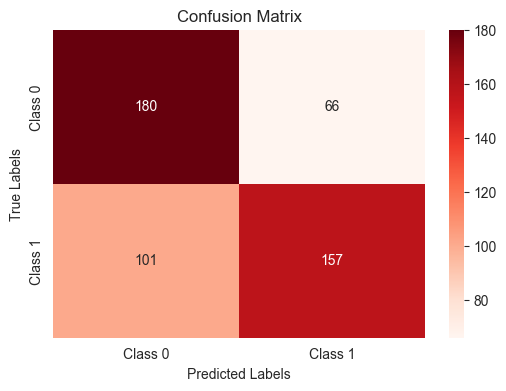


True Positive Rate (TPR): 0.61
True Negative Rate (TNR): 0.73


In [230]:
# Train a logistic regression model
log_reg = LogisticRegression(solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)

# Adjust the decision threshold to optimize for TPR
y_prob_Log = log_reg.predict_proba(X_test)[:, 1]

# Experiment with different thresholds to maximize TPR
thresholds = np.arange(0.05, 0.9, 0.05)
optimal_threshold = 0.05
optimization_sum = 0

for threshold in thresholds:
    y_pred_threshold = (y_prob_Log >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Threshold: {threshold:.2f}, True Positive Rate (TPR): {tpr:.3f}, True Negative Rate (TNR): {tnr:.3f}")
    if tpr + tnr > optimization_sum:
        optimal_threshold = threshold
        optimization_sum = tpr + tnr

# Choose a specific threshold
y_pred_Log = (y_prob_Log >= optimal_threshold).astype(int)

roc_aucLog = roc_auc_score(y_test, y_prob_Log)

print("")
print(f"ROC AUC Score: {roc_aucLog:.2f}")

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_Log))


conf_matrix_Log = confusion_matrix(y_test, y_pred_Log)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_Log, annot=True, fmt='d', cmap='Reds', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate True Positive and True Negative Rates
tn, fp, fn, tp = conf_matrix_Log.ravel()
true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)

print(f"\nTrue Positive Rate (TPR): {true_positive_rate:.2f}")
print(f"True Negative Rate (TNR): {true_negative_rate:.2f}")

fprLog, tprLog, thresholdsLog = roc_curve(y_test, y_prob_Log)


 ### Random Forests

ROC AUC Score: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       246
           1       0.94      0.86      0.90       258

    accuracy                           0.90       504
   macro avg       0.90      0.90      0.90       504
weighted avg       0.90      0.90      0.90       504



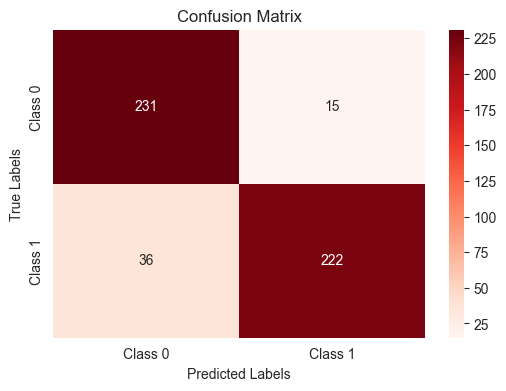


True Positive Rate (TPR): 0.86
True Negative Rate (TNR): 0.94


In [231]:
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_prob_RF = clf.predict_proba(X_test)[:, 1]

threshold = 0.56
y_pred_RF = (y_prob_RF >= threshold).astype(int)

# Calculate the ROC AUC score
roc_aucRF = roc_auc_score(y_test, y_prob_RF)
print(f"ROC AUC Score: {roc_aucRF:.2f}")
print("")

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_RF))

conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_RF, annot=True, fmt='d', cmap='Reds', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate True Positive and True Negative Rates
tn, fp, fn, tp = conf_matrix_RF.ravel()
true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)

print(f"\nTrue Positive Rate (TPR): {true_positive_rate:.2f}")
print(f"True Negative Rate (TNR): {true_negative_rate:.2f}")

fprRF, tprRF, thresholdsRF = roc_curve(y_test, y_prob_RF)


In [198]:
# Experiment with different thresholds for XG Boost
thresholds = np.arange(0.01, 0.95, 0.01)
optimal_threshold = 0.01
optimization_sum = 0

for threshold in thresholds:
    y_pred_threshold = (y_prob_RF >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    #print(f"Threshold: {threshold:.2f}, True Positive Rate (TPR): {tpr:.3f}, True Negative Rate (TNR): {tnr:.3f}")
    if tpr + tnr > optimization_sum:
        optimal_threshold = threshold
        optimization_sum = tpr + tnr

optimal_threshold

np.float64(0.56)

### XG Boost

ROC AUC Score: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       246
           1       0.94      0.86      0.90       258

    accuracy                           0.90       504
   macro avg       0.90      0.90      0.90       504
weighted avg       0.90      0.90      0.90       504



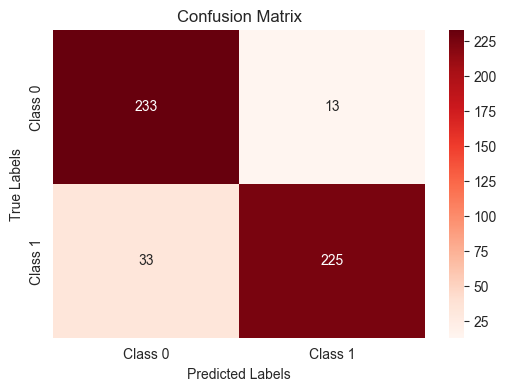


True Positive Rate (TPR): 0.87
True Negative Rate (TNR): 0.95


In [232]:
# Initialize and train the XGBoost classifier
model = XGBClassifier(
    n_estimators=50,
    learning_rate=0.45,
    max_depth=25,
    random_state=42,
    eval_metric='auc'
)

model.fit(X_train, y_train)

# Make probability predictions on the test set
y_pred_XG = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the ROC AUC score
roc_aucXG = roc_auc_score(y_test, y_pred_XG)
print(f"ROC AUC Score: {roc_aucXG:.2f}")
print("")
# Adjust threshold
new_threshold = 0.72
y_pred_new = (y_pred_XG >= new_threshold).astype(int)

# Generate Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_RF))

# Recalculate confusion matrix
conf_matrix_XG = confusion_matrix(y_test, y_pred_new)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_XG, annot=True, fmt='d', cmap='Reds', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate True Positive and True Negative Rates
tn, fp, fn, tp = conf_matrix_XG.ravel()
true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)

print(f"\nTrue Positive Rate (TPR): {true_positive_rate:.2f}")
print(f"True Negative Rate (TNR): {true_negative_rate:.2f}")

fprXG, tprXG, thresholdsXG = roc_curve(y_test, y_pred_XG)


In [218]:
# Experiment with different thresholds for XG Boost
thresholds = np.arange(0.01, 0.95, 0.01)
optimal_threshold = 0.05
optimization_sum = 0

for threshold in thresholds:
    y_pred_threshold = (y_pred_XG >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = conf_matrix.ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    #print(f"Threshold: {threshold:.2f}, True Positive Rate (TPR): {tpr:.3f}, True Negative Rate (TNR): {tnr:.3f}")
    if tpr + tnr > optimization_sum:
        optimal_threshold = threshold
        optimization_sum = tpr + tnr

optimal_threshold

np.float64(0.72)

# Results

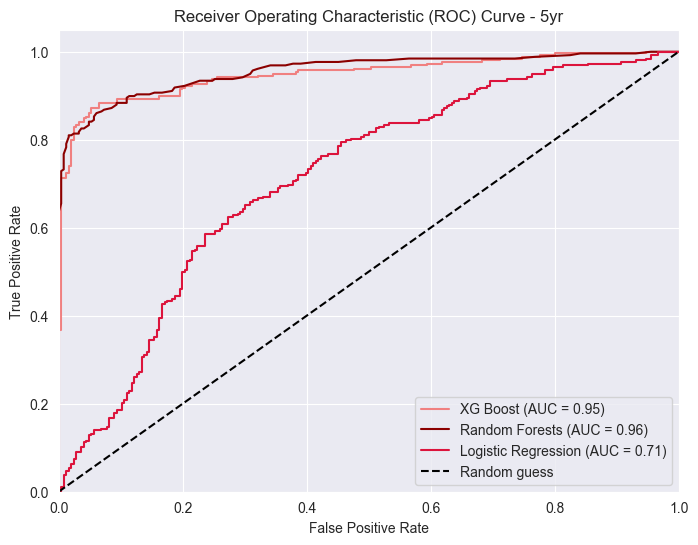

In [236]:
plt.figure(figsize=(8, 6))
plt.plot(fprXG, tprXG, color='lightcoral', label=f'XG Boost (AUC = {roc_aucXG:.2f})')
plt.plot(fprRF, tprRF, color='darkred', label=f'Random Forests (AUC = {roc_aucRF:.2f})')
plt.plot(fprLog, tprLog, color='crimson', label=f'Logistic Regression (AUC = {roc_aucLog:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - 5yr')
plt.legend(loc="lower right")
plt.show()